## データ分析前準備

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:

# ライブラリ読み込み（データ準備で使用）
import numpy as np
import pandas as pd
import IPython as ipy
from pandas import DataFrame
pd.options.display.max_rows = 101
pd.options.display.max_columns = 40

# ライブラリ読み込み（データ可視化で使用）
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set() #seaborneのグラフレイアウト

# ライブラリ読み込み（モデル評価で使用）
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# 環境依存定数
import os
import sys
HOME_DIR = '/Users/ryoma.uehara/PycharmProjects/InfoNear'

# アプリ定数
PYSRC_DIR = os.path.join(HOME_DIR, 'py')
DATA_DIR = os.path.join(HOME_DIR, 'data/wine_quality')
EVAL_DIR = os.path.join(HOME_DIR, 'eval')

# 共通スクリプト呼び出し用にパスを通す
sys.path.append(PYSRC_DIR)

# dataフォルダに移動
os.chdir(DATA_DIR)

# 今回のワイン品質NG演習では、品質（quality）が「3」のものを異常としたいため目的変数を以下の様にする
# - 品質（quality）が「3」を異常（target=1）
# - それ以外を正常（target=0）
def cvt_target(x):
    if x <= 3:
        return 'Low'
    if x >= 7:
        return 'High'
    return 'Mid'

df = pd.read_csv('winequality-red.csv', sep=';')
df['target'] = df['quality'].map(cvt_target)
df.columns = df.columns.map(lambda x: x.replace(' ', '_'))
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Mid
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Mid
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Mid
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,Mid
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Mid


In [3]:
df.target.value_counts()

Mid     1372
High     217
Low       10
Name: target, dtype: int64

In [4]:
from eda import TableOverview
from eda import CategoricalTargetCrossPlot
from eda import CategoricalTargetCrossDisplay
from eda import CategoricalTargetVsVarsBarPlotter
from eda import CategoricalTargetVsVarsHistPlotter
from eda import CategoricalTargetVsVarsViolinPlotter

### 単一量的変数の分布を目的変数別に可視化

#### バイオリン図
　　Y軸：確率分布  
　　X軸：左側は正常ユーザ、右側は不正ユーザ  

In [5]:
def scatter_3d_plot(ax, df, x_col, y_col, z_col, group_col):
    labels = ['Low', 'High', 'Mid']
    dataset = []
    for x in labels:
        xs = df[df[group_col]==x][x_col]
        ys = df[df[group_col]==x][y_col]
        zs = df[df[group_col]==x][z_col]
        dataset.append((xs, ys, zs))

    for data, label in zip(dataset, labels):
        alpha=0.8
        if label == 'Mid':
            alpha=0.3
        ax.scatter(data[0], data[1], data[2], label=label, alpha=alpha)
    ax.set_title('Matplot 3d scatter plot')  # タイトル
    ax.set_xlabel(x_col)  # X軸ラベル
    ax.set_ylabel(y_col)  # Y軸ラベル
    ax.set_zlabel(z_col)  # Z軸ラベル
    ax.legend(loc=2, title=group_col, shadow=True)  # 凡例

In [6]:
from util import plot_util
from mpl_toolkits.mplot3d import axes3d  # Axes3D のために必要

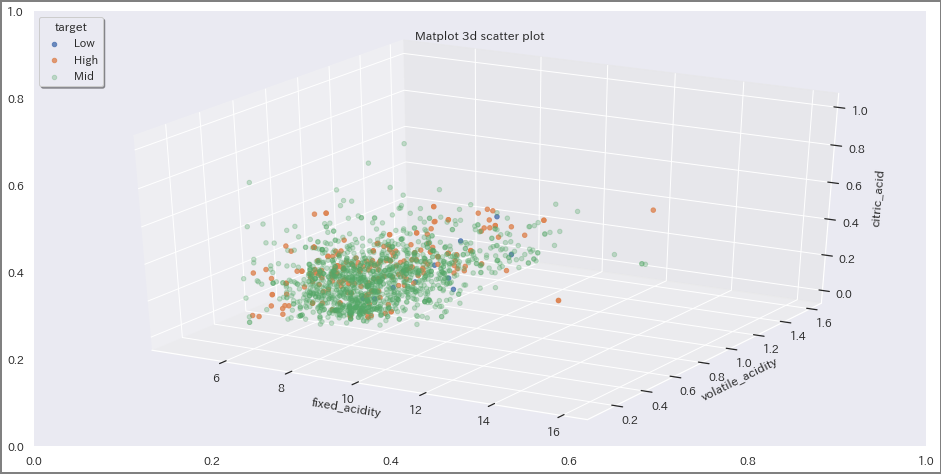

In [7]:
fig, ax = plot_util.get_fig_obj(1, 1, row_size=8, col_size=16)
x_col = 'fixed_acidity'
y_col = 'volatile_acidity'
z_col = 'citric_acid'
group_col = 'target'
ax = fig.add_subplot(1, 1, 1, projection='3d')
scatter_3d_plot(ax, df, x_col, y_col, z_col, group_col)

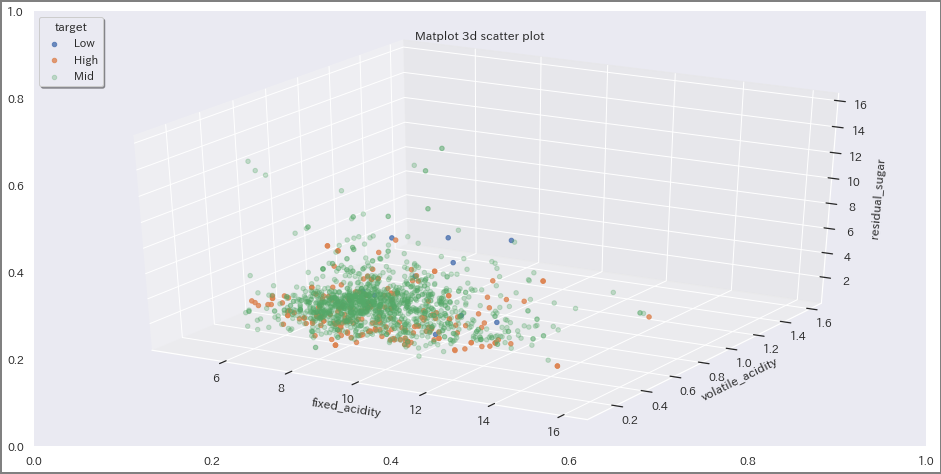

In [8]:
fig, ax = plot_util.get_fig_obj(1, 1, row_size=8, col_size=16)
x_col = 'fixed_acidity'
y_col = 'volatile_acidity'
z_col = 'residual_sugar'
group_col = 'target'
ax = fig.add_subplot(1, 1, 1, projection='3d')
scatter_3d_plot(ax, df, x_col, y_col, z_col, group_col)

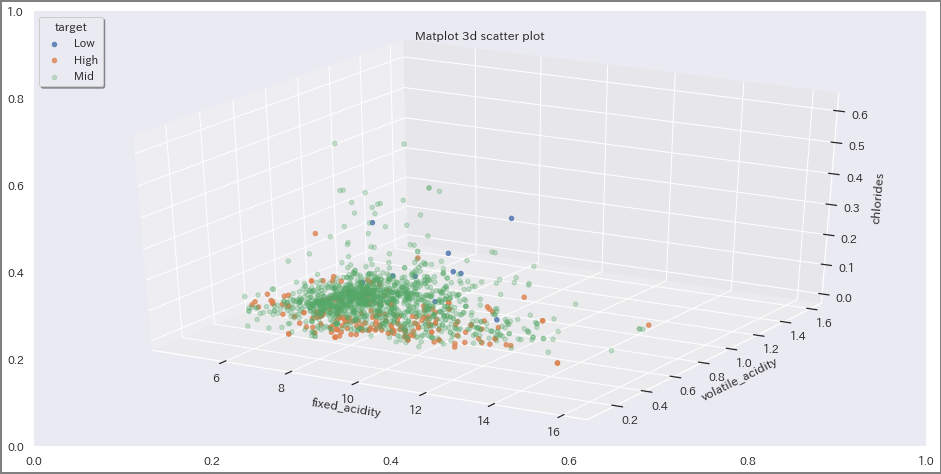

In [9]:
fig, ax = plot_util.get_fig_obj(1, 1, row_size=8, col_size=16)
x_col = 'fixed_acidity'
y_col = 'volatile_acidity'
z_col = 'chlorides'
group_col = 'target'
ax = fig.add_subplot(1, 1, 1, projection='3d')
scatter_3d_plot(ax, df, x_col, y_col, z_col, group_col)

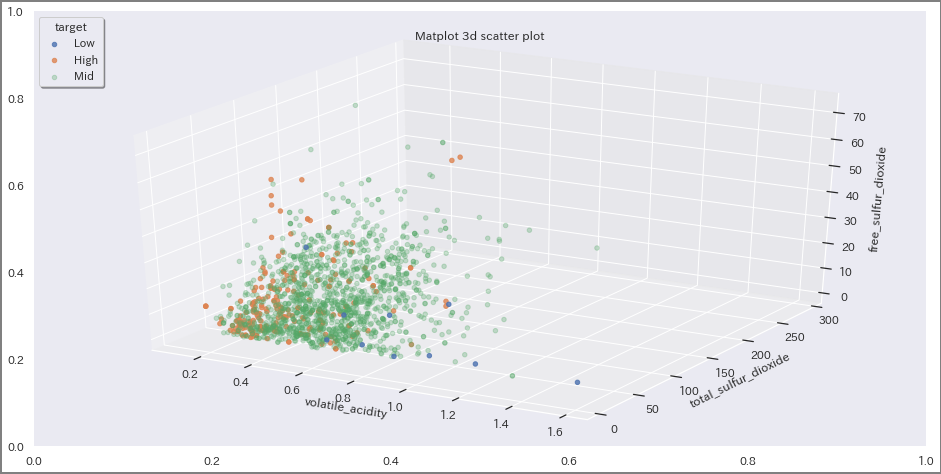

In [10]:
fig, ax = plot_util.get_fig_obj(1, 1, row_size=8, col_size=16)
x_col = 'volatile_acidity'
y_col = 'total_sulfur_dioxide'
z_col = 'free_sulfur_dioxide'
group_col = 'target'
ax = fig.add_subplot(1, 1, 1, projection='3d')
scatter_3d_plot(ax, df, x_col, y_col, z_col, group_col)

---
# 品質の高くないデータ(qualityが4〜6)のデータを除外して分析してみる
- 3次元グラフ、データが多いと見づらいためワイン品質の高いデータと低いデータを使用し、可視化してみる
- 高品質、低品質の違いを見た方が説明変数が効くの顕著に出るのではないか（見てみよう！）
---

In [11]:
df = df[df.target != 'Mid']

In [12]:
df.target.value_counts()

High    217
Low      10
Name: target, dtype: int64

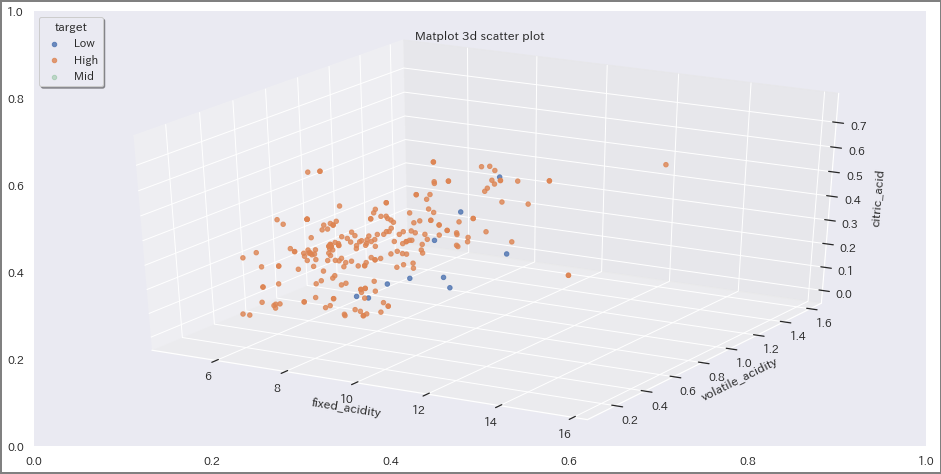

In [13]:
fig, ax = plot_util.get_fig_obj(1, 1, row_size=8, col_size=16)
x_col = 'fixed_acidity'
y_col = 'volatile_acidity'
z_col = 'citric_acid'
group_col = 'target'
ax = fig.add_subplot(1, 1, 1, projection='3d')
scatter_3d_plot(ax, df, x_col, y_col, z_col, group_col)

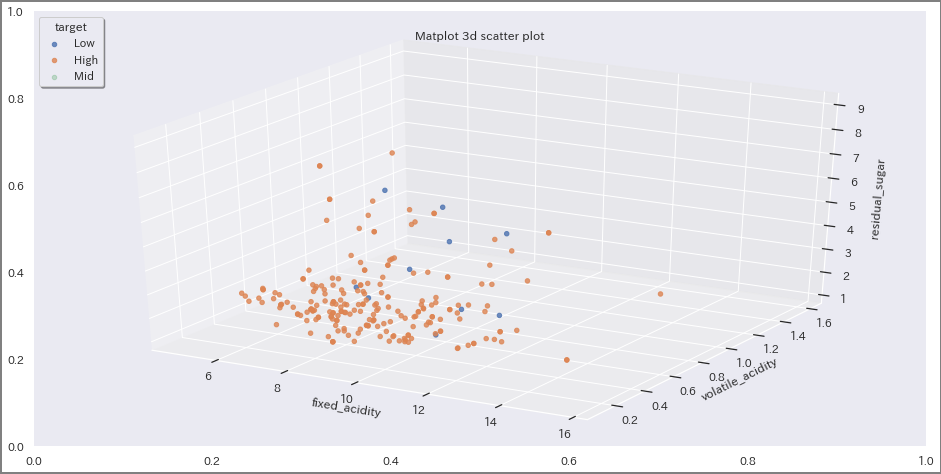

In [14]:
fig, ax = plot_util.get_fig_obj(1, 1, row_size=8, col_size=16)
x_col = 'fixed_acidity'
y_col = 'volatile_acidity'
z_col = 'residual_sugar'
group_col = 'target'
ax = fig.add_subplot(1, 1, 1, projection='3d')
scatter_3d_plot(ax, df, x_col, y_col, z_col, group_col)

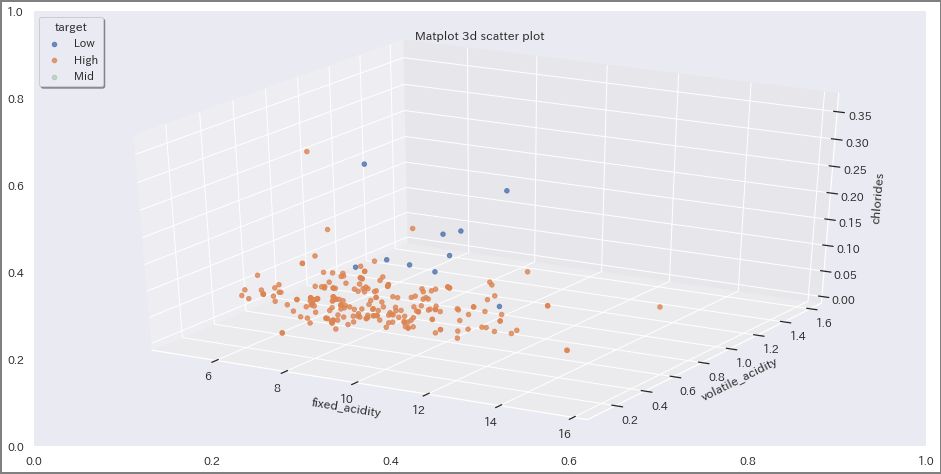

In [15]:
fig, ax = plot_util.get_fig_obj(1, 1, row_size=8, col_size=16)
x_col = 'fixed_acidity'
y_col = 'volatile_acidity'
z_col = 'chlorides'
group_col = 'target'
ax = fig.add_subplot(1, 1, 1, projection='3d')
scatter_3d_plot(ax, df, x_col, y_col, z_col, group_col)

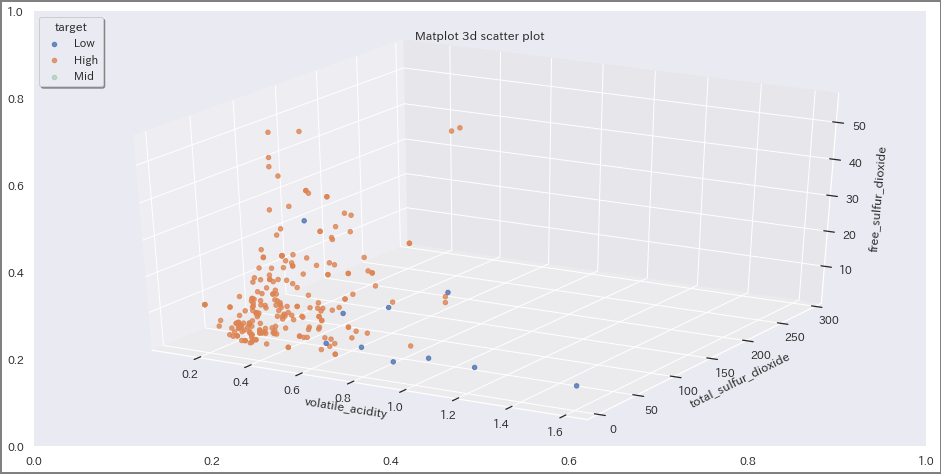

In [16]:
fig, ax = plot_util.get_fig_obj(1, 1, row_size=8, col_size=16)
x_col = 'volatile_acidity'
y_col = 'total_sulfur_dioxide'
z_col = 'free_sulfur_dioxide'
group_col = 'target'
ax = fig.add_subplot(1, 1, 1, projection='3d')
scatter_3d_plot(ax, df, x_col, y_col, z_col, group_col)

---
# 考察
- 4つグラフを出したが、最後のグラフでは、高品質なものは左下に分布しているため、「volatile_acidity、total_sulfur_dioxide、free_sulfur_dioxide」は効くかも？！この調子で他のものも確認してみる。
---